<a href="https://colab.research.google.com/github/vuthede/Audiovisual-Synthesis/blob/master/grounded_sam_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Grounded SAM Inpainting Demo](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

## Why this project?

- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks.
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text.
- The combination of the two models enable **to detect and segment everything** with text inputs!



## Install

In [1]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1807, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1807 (delta 9), reused 1 (delta 1), pack-reused 1789 (from 2)
Receiving objects: 100% (1807/1807), 155.84 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (830/830), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:

import torch
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert
# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict
import supervision as sv
from huggingface_hub import hf_hub_download
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline

def denormalize_bbox(bbox, width, height):
    """
    Converts normalized bounding boxes to pixel coordinates.
    bbox: [center_x, center_y, width, height] (normalized)
    width, height: Image dimensions
    """
    center_x, center_y, box_width, box_height = bbox
    x1 = (center_x - box_width / 2) * width   # Top-left X
    y1 = (center_y - box_height / 2) * height # Top-left Y
    x2 = (center_x + box_width / 2) * width   # Bottom-right X
    y2 = (center_y + box_height / 2) * height # Bottom-right Y
    return [x1, y1, x2, y2]

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

def detect(image,image_source,text_prompt, model, box_threshold = 0.3, text_threshold = 0.1):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )
#   print(boxes)
  # annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  # annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  # return annotated_frame, boxes
  # Get image dimensions
  img_width, img_height, _ = image_source.shape
  # np array to PIL image
  image_source = Image.fromarray(image_source)

  # Create a drawable object
  draw = ImageDraw.Draw(image_source)
  mask = Image.new('L', image_source.size, 0)

  # Loop through bounding boxes and draw them
  for bbox in boxes:
      x1, y1, x2, y2 = denormalize_bbox(bbox, img_width, img_height)
      draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
      mask.paste(255, (int(x1),int(y1),int(x2),int(y2)))
  # Generate the mask

  return image_source, mask

def load_model_inpainter(device='cpu'):
    pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
    pipeline = pipeline.to(device)
    return pipeline

class WaterMarkRemovalusingFoundationModel:
    device='cpu'
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    def __init__(self):
        ckpt_repo_id = "ShilongLiu/GroundingDINO"
        ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
        ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
        self.groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device=self.device)
        self.inpaint_model = load_model_inpainter(device=self.device)

    def forward(self, Pil_in):
        original_size = Pil_in.size  # (width, height)


        # Preprocess
        image_transformed, _ = self.transform(Pil_in, None)
        print(f'Transformed image shape: {image_transformed.shape}')
        # Detect water mark on image
        nparray_original_image = np.asarray(Pil_in)
        image_sources, mask = detect(image_transformed, nparray_original_image, text_prompt="watermark, text", model=self.groundingdino_model)
        print(f'Detected watermark and create mask with shape :{mask.shape}!')
        # Inpaint
        prompt = "Remove the watermark or logo or text "
        inpainted_image = self.inpaint_model(prompt=prompt, image=Image.fromarray(Pil_in), mask_image=mask ).images[0]
        print(f'Inpainting done with shape: {inpainted_image.shape}')
        # Resize the inpainted image to the original input image size
        inpainted_image_resized = inpainted_image.resize(original_size, Image.LANCZOS)  # Use LANCZOS for high-quality resizing
        return inpainted_image_resized


  # Load the model
  model = WaterMarkRemovalusingFoundationModel()
  # Load the image
  image_path = "../test_watermark.jpg"
  image = Image.open(image_path).convert("RGB")
  # Run the model
  inpainted_image = model.forward(image)
  # Display the inpainted image

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` 

Transformed image shape: torch.Size([3, 800, 800])


AttributeError: 'Image' object has no attribute 'shape'

## Imports

In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

## Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-12-15 09:17:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   201MB/s    in 17s     

2024-12-15 09:17:17 (145 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



### Stable Diffusion (Inpainting)

In [ ]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Inference

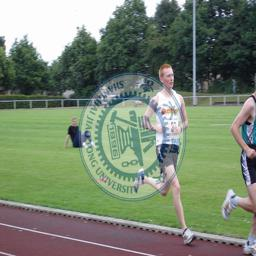

In [ ]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

# download_image(image_url, local_image_path)
# image_source, image = load_image("../test_watermark.png")
image_source, image = load_image("../18.jpg")
# image_source, image = load_image("../39.jpg")
# image_source, image = load_image("../27.jpg")



Image.fromarray(image_source)
# image_source = Image.open("../test_watermark.png")
# image_source = np.array(image_source)

## Grounding DINO for detection

In [ ]:
# Denormalize bounding boxes to pixel values
def denormalize_bbox(bbox, width, height):
    """
    Converts normalized bounding boxes to pixel coordinates.
    bbox: [center_x, center_y, width, height] (normalized)
    width, height: Image dimensions
    """
    center_x, center_y, box_width, box_height = bbox
    x1 = (center_x - box_width / 2) * width   # Top-left X
    y1 = (center_y - box_height / 2) * height # Top-left Y
    x2 = (center_x + box_width / 2) * width   # Bottom-right X
    y2 = (center_y + box_height / 2) * height # Bottom-right Y
    return [x1, y1, x2, y2]

# detect object using grounding DINO
def detect(image,image_source,text_prompt, model, box_threshold = 0.3, text_threshold = 0.1):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )
  print(boxes)
  # annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  # annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  # return annotated_frame, boxes




  # Get image dimensions
  img_width, img_height, _ = image_source.shape
  # np array to PIL image
  image_source = Image.fromarray(image_source)

  # Create a drawable object
  draw = ImageDraw.Draw(image_source)
  mask = Image.new('L', image_source.size, 0)

  # Loop through bounding boxes and draw them
  for bbox in boxes:
      x1, y1, x2, y2 = denormalize_bbox(bbox, img_width, img_height)
      draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
      mask.paste(255, (int(x1),int(y1),int(x2),int(y2)))
  # Generate the mask

  return image_source, mask

tensor([[0.4723, 0.5328, 0.3321, 0.4873],
        [0.5151, 0.5320, 0.4252, 0.5027]])


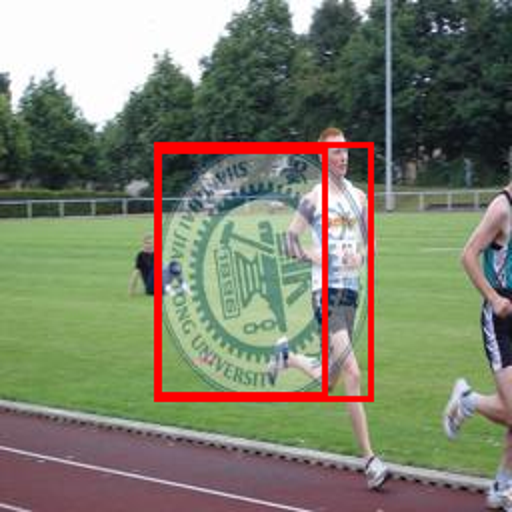

In [ ]:
image_sources, mask = detect(image,image_source, text_prompt="watermark, text", model=groundingdino_model)

#concat horizontally the image and the mask USING pil
image_sources.resize((512, 512))

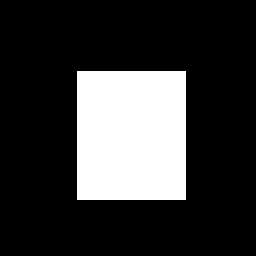

In [ ]:
mask


## Using inpainting model

In [ ]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
)
pipeline = pipeline.to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

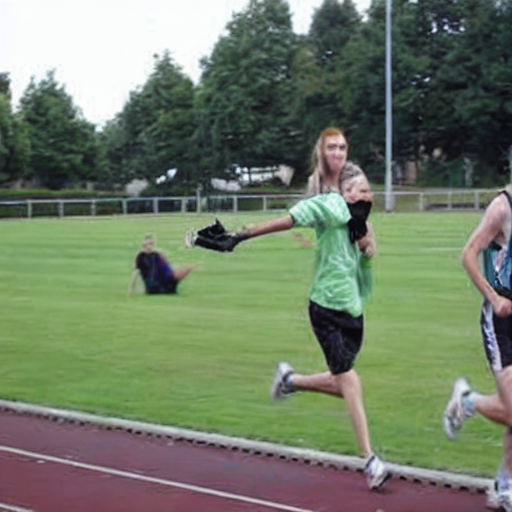

In [ ]:
prompt = "Remove the watermark or logo or text "
image = pipeline(prompt=prompt, image=Image.fromarray(image_source), mask_image=mask ).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

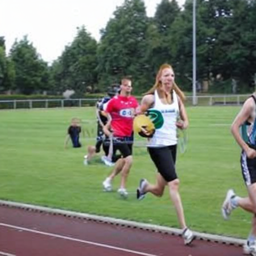

In [ ]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h= image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))
prompt="Remove the watermark seemlessly"
negative_prompt="people, low resolution, ugly, text"
seed = 32 # for reproducibility

generated_image = generate_image(image=Image.fromarray(image_source), mask=mask, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [ 96, 112, 125],
        [ 69,  85,  98],
        [ 83,  99, 112]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [ 50,  66,  79],
        [ 68,  84,  97],
        [106, 122, 135]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [ 60,  77,  87],
        [ 78,  95, 105],
        [106, 123, 133]],

       ...,

       [[140, 112, 124],
        [163, 135, 147],
        [196, 168, 180],
        ...,
        [122, 118, 133],
        [110, 107, 124],
        [132, 129, 148]],

       [[ 96,  70,  83],
        [ 99,  73,  86],
        [106,  80,  93],
        ...,
        [148, 145, 162],
        [157, 155, 176],
        [182, 180, 202]],

       [[ 98,  72,  85],
        [ 98,  72,  85],
        [ 97,  71,  84],
        ...,
        [106, 105, 123],
        [170, 168, 190],
        [175, 175, 199]]], dtype=uint8)
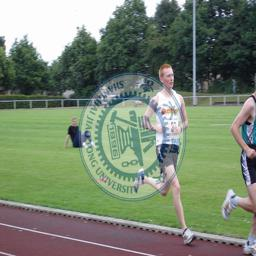

## SAM for segmentation

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

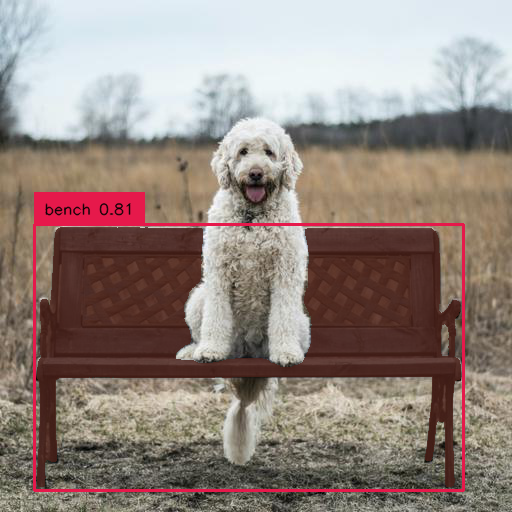

In [ ]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

## Stable Diffusion for inpainting

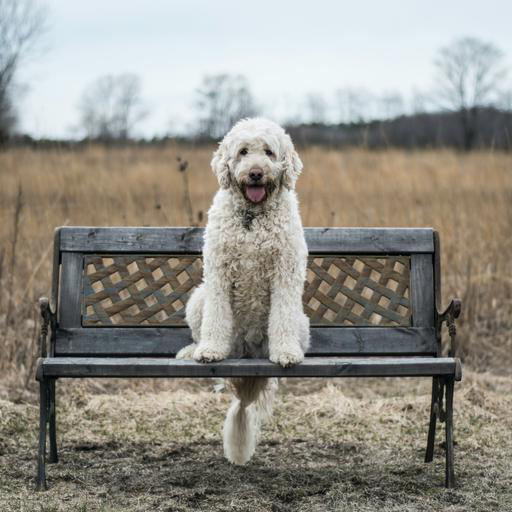

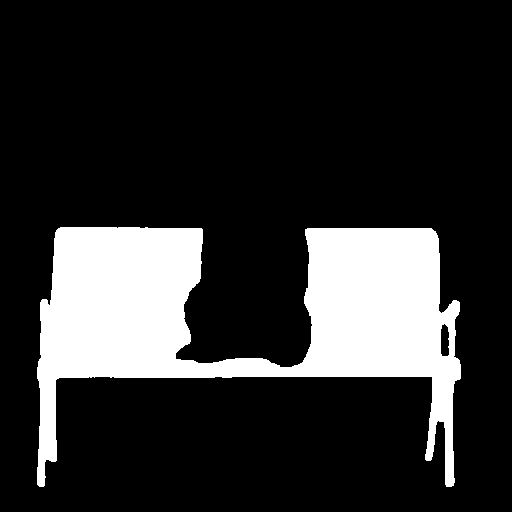

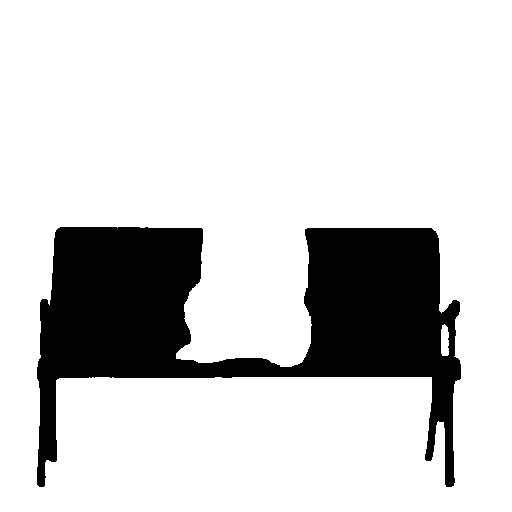

In [ ]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [ ]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

  0%|          | 0/50 [00:00<?, ?it/s]

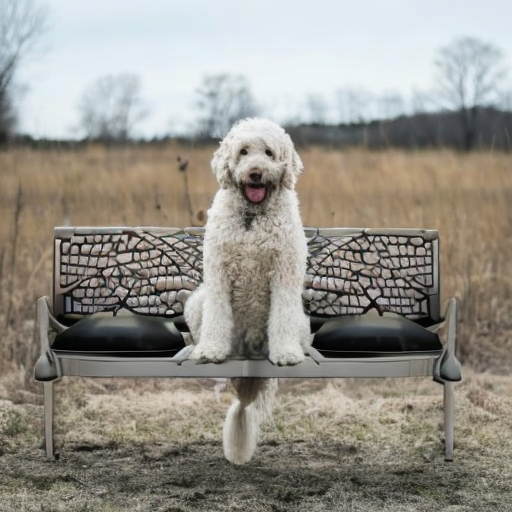

In [ ]:
prompt="A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

  0%|          | 0/50 [00:00<?, ?it/s]

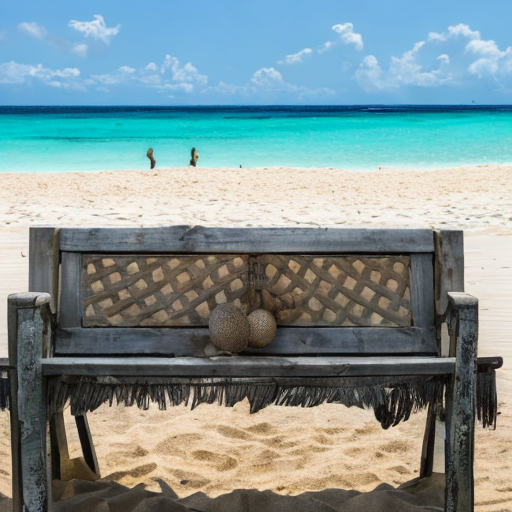

In [ ]:
prompt="a beach with turquoise water, sand, and coconuts"
negative_prompt="people, low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image